In [ ]:
# 假设一个 x 轴长 750m，y 轴长 1000m 的矩形区域，分别划分为 15 格与 20 格。顶部高程为 5m，底部高程为 -50m 的潜水含水层。时间上共划分为三个应力周期。

# 研究区最北部为定水头边界，水位在 3 个应力周期的（初始水头，结束水头）分别为 (3, 3)，(3, 6)，(6, 1) m。
# 区内有三口井，坐标分别为 A(3, 3)，B(5, 11)，C(18, 5)。三口井的抽/补水速率 (m3/d) 为：

#    井	    周期 0	 周期 1	 周期 2
# A (3, 3)	-500	-200	-100
# B (5, 11)	-100	 200	 500
# C (18, 5)	 600	-350	 100
# 另有一条河流从 x = 14 位置经过，河床底部厚度为 1 m。河流水位在 3 个应力周期分别为 5，1，4 m。

# 区内垂直渗透系数均为 1 m/d，水平渗透系数如图所示。
#https://zhuanlan.zhihu.com/p/427533365


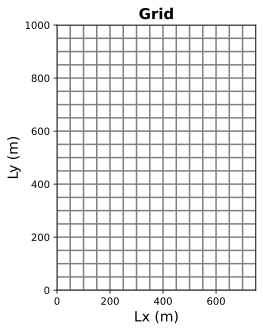

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import flopy
import numpy as np
import pandas as pd
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
temp_dir = TemporaryDirectory()
workspace = os.path.join(temp_dir.name)
# MODFLOW
mymodel = flopy.modflow.Modflow('mf2005Unsteadyflow', exe_name="mf2005", model_ws = workspace)
# DIS
#非稳定流的离散化仍然是使用 DIS。但与稳定流不同的是，本次离散化需要划分不同的应力周期和时间。
#以下是对空间上的划分
Lx = 750.0                               # x 长度
Ly = 1000.0                              # y 长度 
ztop = 5.0                               # z 顶部高程
zbot = -50.0                             # z 底部高程
nlay = 1                                 # 含水层层数
nrow = 20                                # 行数
ncol = 15                                # 列数
delc = Lx/ncol                           # x 步长
delr = Ly/nrow                           # y 步长
botm = np.linspace(ztop, zbot, nlay + 1) # z 每一层的底部高程 -50  
# numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)创建等差数列
#start:返回样本数据开始点stop:返回样本数据结束点num:生成的样本数据量，默认为50

#以下是对时间上的划分
# nper 设为 3，意味着本次模拟共有 3 个应力周期。
# steady 是一个列表，列表内用布尔类型来表示每个应力周期内是否是稳定流，其中 True 为稳定流，False 为非稳定流。
# 第一个周期为稳定流，以便创建一个初始水头作为后续模拟的基础。
# perlen 也是一个列表，用于表示每个应力周期的长度。在稳定流周期中，长度可以任意值；在非稳定流中，不同的数值代表了不同的天数。本次均为 100 天。
# nstp 代表了每个应力周期的时间步长。可以理解为是时间上的分辨率。本次设为 100，即将 perlen 中一个应力周期的 100 天划分为 100 次。
nper = 3
steady = [True, False, False]
perlen = [1, 100, 100]
nstp = [1, 100, 100]

#将上述模型进行离散化 Discretization
dis = flopy.modflow.ModflowDis(mymodel, nlay, nrow, ncol, delr = delr,
                               delc = delc, top = ztop, botm = botm[1:], 
                               nper = nper, perlen = perlen, nstp = nstp, steady = steady)

############################################################################################################
#可以使用flopy自带的函数查看建模结果
modelmap = flopy.plot.PlotMapView(model = mymodel, layer = 0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()



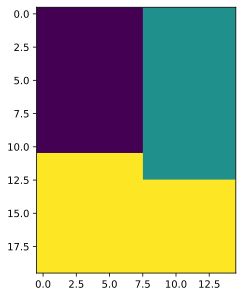

In [2]:
# BAS   Basic Package
# BAS 主要输入的参数是每个单元格的 ibound 和 strt 的值


# ibound 包括三种状态：


# ibound < 0，表明是定水头的单元，通常用 -1 表示；


# ibound = 0，表明是隔水单元；


# ibound > 0，表明是活动单元，通常用 1 表示。


# 在稳定流中，我们曾将定水头的边界设为 -1。一旦设为 -1，水头边界值将无法发生改变。


# 因此在非稳定流中，采用了 CHD 包来控制边界的指定水头，故所有单元的 ibound 值均设为 >0，本次用 1 表示。初始水头均设为 10。


ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)


strt = 10.0 * np.ones((nlay, nrow, ncol), dtype=np.float32)


bas = flopy.modflow.ModflowBas(mymodel, ibound=ibound, strt=strt)



# LPF Layer-Property Flow Package
# LPF 包与稳定流中的设置一致，直接定义含水层特性即可。


laytyp = 1  # 含水层类型


vka = 1.0  # 垂直渗透系数，单位：m/d


hk = np.ones((nlay, nrow, ncol), dtype=np.float32)  # 水平渗透系数，单位：m/d


hk[:, 0:11, 0:8] = 1.0


hk[:, 0:13, 8:16] = 3.0


hk[:, 11:21, 0:8] = 5.0


hk[:, 13:21, 8:16] = 5.0


sy = 0.1  # 给水度，单位：1/m


ss = 1.0e-4  # 单位储水量，单位：1/m


lpf = flopy.modflow.ModflowLpf(
    model=mymodel, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=1
)



# 检查水平渗透系数是否设置正确


plt.imshow(hk[0])

In [3]:
# CHD
#CHD 包用于指定水头边界，用于模拟非稳定流随时间变化的边界条件。CHD 使用字典来表示不同应力周期的水头边界情况，即：
# stress_period_data =
# {0: [
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead]
#     ],
# 1:  [
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead]
#     ], ...
# kper:
#     [
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead],
#     [lay, row, col, shead, ehead]
#     ]
# }
# 这里的键表示为应力周期，用 0, 1, 2... 来表示。lay，row 和 col 即为水头边界的位置索引。
# shead 和 ehead 为该点在其应力周期内的初始水头和结束水头。若水头值不一致，则 MODFLOW 自动在其应力周期内不同步长进行插值，从而反映水头边界的一个渐变过程。
# 应力周期 0
shead_0 = 3
ehead_0 = 3
bound_sp_0 = []     
# 应力周期 1
shead_1 = 3
ehead_1 = 6
bound_sp_1 = []
# 应力周期 2
shead_2 = 6
ehead_2 = 1
bound_sp_2 = []
for lay in range(nlay):
    for col in range(ncol):
        bound_sp_0.append([lay, 0, col, shead_0, shead_0])
        bound_sp_1.append([lay, 0, col, shead_1, ehead_1])
        bound_sp_2.append([lay, 0, col, shead_2, ehead_2])

chd_spd = {0: bound_sp_0, 1: bound_sp_1, 2: bound_sp_2}
chd = flopy.modflow.ModflowChd(model= mymodel, stress_period_data = chd_spd)


# WEL 井的设置与边界类似，也是使用字典形式来储存。即一个键值对代表了该应力周期内井的位置和抽/补水效率。
wel_spd = {0: [[0, 3, 3, -500], [0, 5, 11, -100], [0, 18, 5,  600]],
           1: [[0, 3, 3, -200], [0, 5, 11,  200], [0, 18, 5, -350]],
           2: [[0, 3, 3, -100], [0, 5, 11,  500], [0, 18, 5,  100]]}
wel = flopy.modflow.ModflowWel(mymodel, stress_period_data = wel_spd)



In [4]:
# RIV  河流。河流的水位若是高于其正下方的含水层水位，将会根据河床沉积物的渗透系数对地下水进行补给，反之将对其排泄。
# stress_period_data =
# {0: [
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot]
#     ],
# 1:  [
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot]
#     ], ...
# kper:
#     [
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot],
#     [lay, row, col, stage, cond, rbot]
#     ]
# }
k_rivbott = 1  # 河床底部渗透系数，m/d
thick_rivbott = 1  # 河床沉积物厚度，m
cond = k_rivbott * (delr) * (delc) / (thick_rivbott)  # conductance, m2/d
r_bott = 0  # 河底高程
riv_stage = [1, 5, 2]  # 河流水位
riv_sp_0 = []  # 应力周期 0
riv_sp_1 = []  # 应力周期 1
riv_sp_2 = []  # 应力周期 2
for i in range(ncol):
    riv_sp_0.append([0, 14, i, riv_stage[0], cond, r_bott])
    riv_sp_1.append([0, 14, i, riv_stage[1], cond, r_bott])
    riv_sp_2.append([0, 14, i, riv_stage[2], cond, r_bott])
riv_spd = {0: riv_sp_0, 1: riv_sp_1, 2: riv_sp_2}
riv = flopy.modflow.ModflowRiv(model=mymodel, stress_period_data=riv_spd)


# OC Output Control
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(
    mymodel, stress_period_data=stress_period_data, compact=True
)
# PCG
pcg = flopy.modflow.ModflowPcg(model=mymodel)
# RUN
mymodel.write_input()
success, mfoutput = mymodel.run_model(pause=False, report=True)
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following executable to run the model: ..\..\..\..\..\Environment\MF2005.1_12\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf2005Unsteadyflow.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/08 15:24:23

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress peri

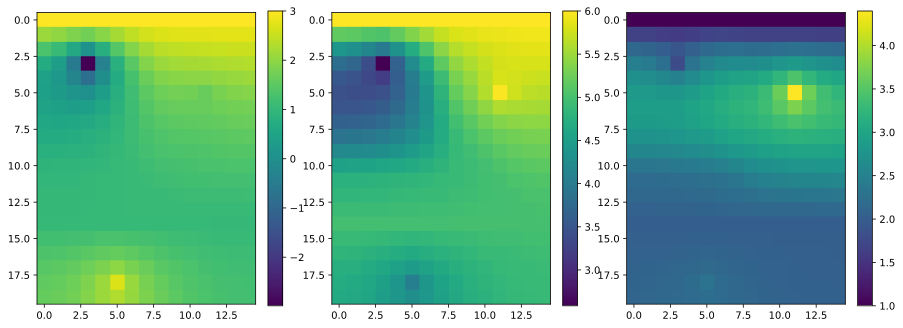

In [5]:
#结果处理
#提取每个应力周期（即 perlen[0], perlen[0] + perlen[1] 和 perlen[0] + perlen[1] + perlen[2]）最后一个时间步长的水头和流向，作为不同应力周期的模拟结果。
headobj = flopy.utils.binaryfile.HeadFile("./mf2005Unsteadyflow/mf2005Unsteadyflow.hds")
budgobj = flopy.utils.binaryfile.CellBudgetFile("./mf2005Unsteadyflow/mf2005Unsteadyflow" + ".cbc")
times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]]
head = {}
frf = {}
fff = {}
for stress_per, time in enumerate(times):
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time)
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time)
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time)
#########
#利用 Matplotlib 绘制三个应力周期的水头场。
# head
fig = plt.figure(figsize=(15, 45))
ax0 = fig.add_subplot(1, 3, 1)
im0 = ax0.imshow(head['sp0'][0])
plt.colorbar(im0, fraction = 0.06, pad = 0.05)
ax1 = fig.add_subplot(1, 3, 2)
im1 = ax1.imshow(head['sp1'][0])
plt.colorbar(im1, fraction = 0.06, pad = 0.05)
ax2 = fig.add_subplot(1, 3, 3)
im2 = ax2.imshow(head['sp2'][0])
plt.colorbar(im2, fraction = 0.06, pad = 0.05)
#########


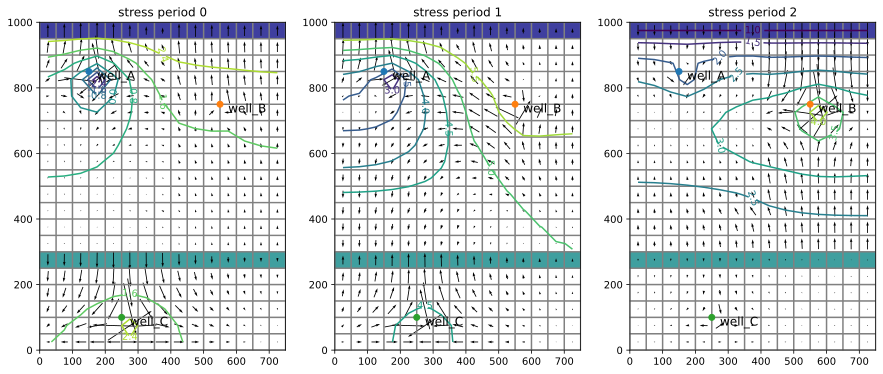

In [6]:
# fd
#利用 Flopy 自带的 PlotMapView 绘制流向和水头。
fig = plt.figure(figsize = (15, 45))
mytimes = [perlen[0], perlen[0] + perlen[1], perlen[0] + perlen[1] + perlen[2]]
for iplot, time in enumerate(mytimes):
    head = headobj.get_data(totim = time)
    frf = budgobj.get_data(text = "FLOW RIGHT FACE", totim = time)[0]
    fff = budgobj.get_data(text = "FLOW FRONT FACE", totim = time)[0]
    
    ax = fig.add_subplot(1, len(mytimes), iplot + 1, aspect = "equal")
    ax.set_title("stress period " + str(iplot))
    
    pmv = flopy.plot.PlotMapView(model = mymodel, layer = 0, ax = ax)
    qm = pmv.plot_ibound()
    lc = pmv.plot_grid() # grid
    qm = pmv.plot_bc("CHD", alpha = 0.5)
    riv = pmv.plot_bc("RIV", alpha = 0.5)
    
    if head.min() != head.max():
        cs = pmv.contour_array(head)
        plt.clabel(cs, inline = 1, fontsize = 10, fmt = "%1.1f")
        quiver = pmv.plot_vector(frf, fff)
    # well  
    wpt0 = (150.0, 850.0)
    wpt1 = (550.0, 750.0)
    wpt2 = (250.0, 100.0)
    mfc = "None"
    if (iplot + 1) == len(mytimes):
        mfc = "black"
    ax.plot(wpt0[0], wpt0[1], lw = 0, marker="o")
    ax.text(wpt0[0] + 25, wpt0[1] - 25, "well_A", size=12, zorder=12)
    ax.plot(wpt1[0], wpt1[1], lw = 0, marker="o")
    ax.text(wpt1[0] + 25, wpt1[1] - 25, "well_B", size=12, zorder=12)
    ax.plot(wpt2[0], wpt2[1], lw = 0, marker="o")
    ax.text(wpt2[0] + 25, wpt2[1] - 25, "well_C", size=12, zorder=12)